In [1]:
import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import DataLoader, TensorDataset

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import random

from scipy import ndimage as ndi
from skimage.util import random_noise


# our own imports
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import lenet_model_and_optimizer

from MNIST32 import MNIST32, MNIST256

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


## Load the trained model, test data and feature attributions

In [2]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_32_10000.pkl', 'rb'))
testset = torch.utils.data.TensorDataset(x_monitor, c_monitor)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

In [3]:
def model_and_optimizer():
    return lenet_model_and_optimizer(lr=1e-3)

model, _ = model_and_optimizer()
model.load_state_dict(torch.load('./models/mnist32_lenet.pth'))
#model.load_state_dict(torch.load("./models/mnist_32_adv_robust_l2.pt"))
model.to(device)
model.eval()
util.test(model, testloader, device)

Test Error:  0.0103


0.0103

In [4]:
inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]
grad_list, int_grad_list, igx_list, smooth_grad_list = torch.load('./output/mnist32_feature_attributions.pkl')

In [5]:
random_vectors_list = [np.random.normal(size = grad_list[0].shape) for _ in range(len(t_monitor))]

In [6]:
frac_random_its = util.tangent_space_ratio(random_vectors_list, t_monitor)
frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor)
frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor)
frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor) 
frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor)

In [7]:
np.mean(frac_random_its), np.std(frac_random_its)/10000, np.sqrt(10/32**2)

(0.09622916953542417, 2.152478032053006e-06, 0.09882117688026186)

In [8]:
predictions = []
for x in tqdm(x_monitor):
    img = dcn(x)
    pred = model(torch.tensor(img).unsqueeze(0).cuda()).argmax().item()
    predictions.append(pred)
predictions = torch.tensor(predictions)

100%|██████████| 10000/10000 [00:04<00:00, 2049.08it/s]


# Plots with on- and off-manifold parts

In [9]:
from util import plot_saliency, plot_normalized_saliency, plot_saliency_with_image_contour, visualize

In [10]:
def on_off_plot(attribtions, fractions, max_fractions, q=0.9):
    if max_fractions:
        max_indices = []
        for c in range(10):
            class_indices = np.where(c_monitor == c)[0]           # indices where the true class is c
            class_quantile = np.quantile(np.array(fractions)[class_indices], q)
            pred_indices = np.where(predictions == c)[0]          # indices where we predicted class c
            indices = np.where(np.array(fractions) > class_quantile)[0] # where the fraction in tangent space is additionally larger than the class-quantile
            indices = list(set(indices).intersection(class_indices))
            indices = list(set(indices).intersection(pred_indices))  # indices where we correctly predicted class c
            indices = np.random.choice(indices, size=10, replace=True if len(t_monitor) < 5000 else False)
            #visualize(model, [inputs[i] for i in indices], [grad_list[i] for i in indices], [t_monitor[i] for i in indices])    
            # the picture in the class that has the largest fraction in tangent space
            max_indices.append(np.where(fractions == max(np.array(fractions)[indices]))[0][0])

        visualize(model, [inputs[i] for i in max_indices], [attribtions[i] for i in max_indices], [t_monitor[i] for i in max_indices], show_predictions=False)   
        return max_indices
    else:
        any_indices = []
        for c in range(10):
            class_indices = np.where(c_monitor == c)[0]           # indices where the true class is c
            pred_indices = np.where(predictions == c)[0]          # indices where we predicted class c
            indices = list(set(class_indices).intersection(pred_indices))    
            indices = np.random.choice(indices, size=10, replace=True if len(t_monitor) < 5000 else False)
            #visualize(model, [inputs[i] for i in indices], [grad_list[i] for i in indices], [t_monitor[i] for i in indices], with_contour=False)    
            # just any picture from the class
            any_indices.append(indices[0])

        visualize(model, [inputs[i] for i in any_indices], [attribtions[i] for i in any_indices], [t_monitor[i] for i in any_indices], show_predictions=False)  

## The gradient

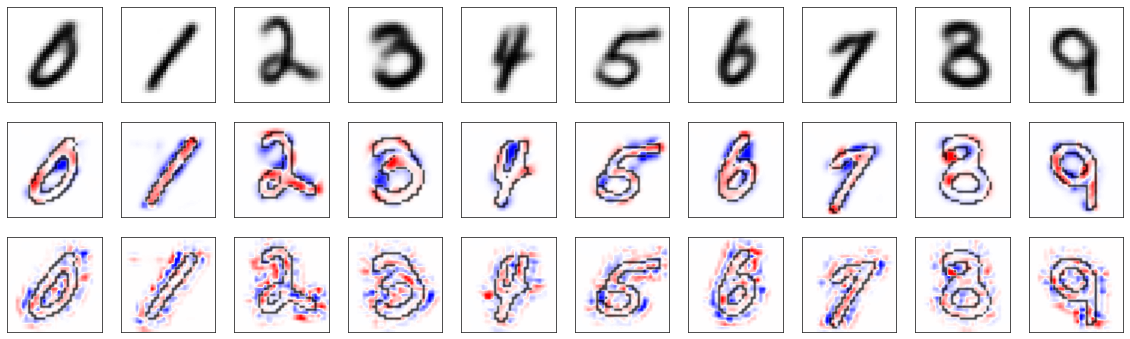

In [119]:
np.random.seed(0)
grad_max_indices = on_off_plot(grad_list, frac_grad_its, True, q=0.25)
plt.savefig('./figures/mnist_32_gradient.pdf', bbox_inches = "tight")

## Integrated Gradients

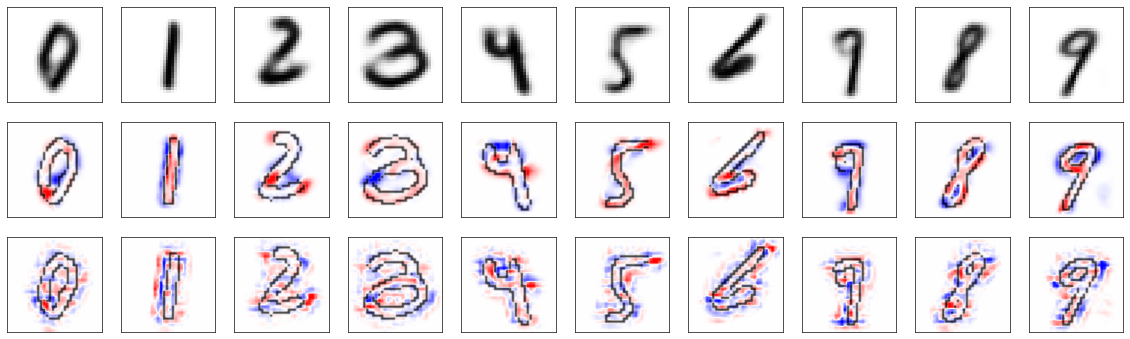

In [120]:
np.random.seed(1)
grad_max_indices = on_off_plot(int_grad_list, frac_int_grad_its, True, q=0.25)
plt.savefig('./figures/mnist_32_int_grad.pdf', bbox_inches = "tight")

## Smoothgrad

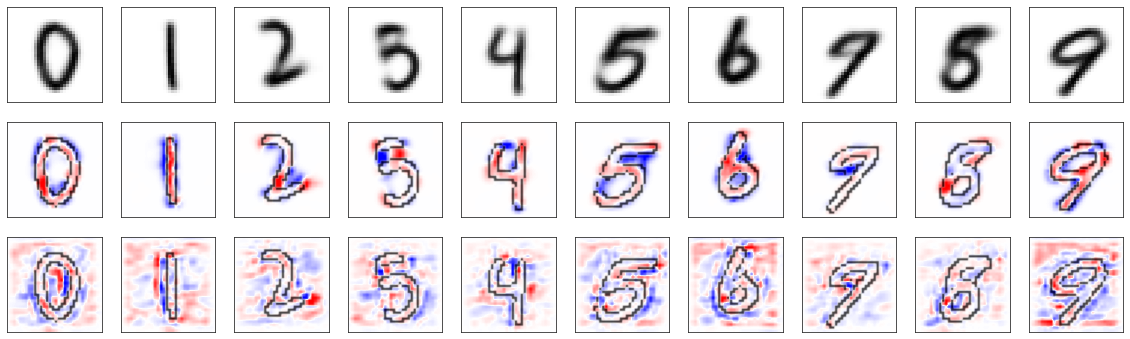

In [125]:
np.random.seed(6)
sg_grad_max_indices = on_off_plot(smooth_grad_list, frac_smooth_grad_its, True, q=0.25)
plt.savefig('./figures/mnist_32_smooth_grad.pdf', bbox_inches = "tight")

## Random Attributions

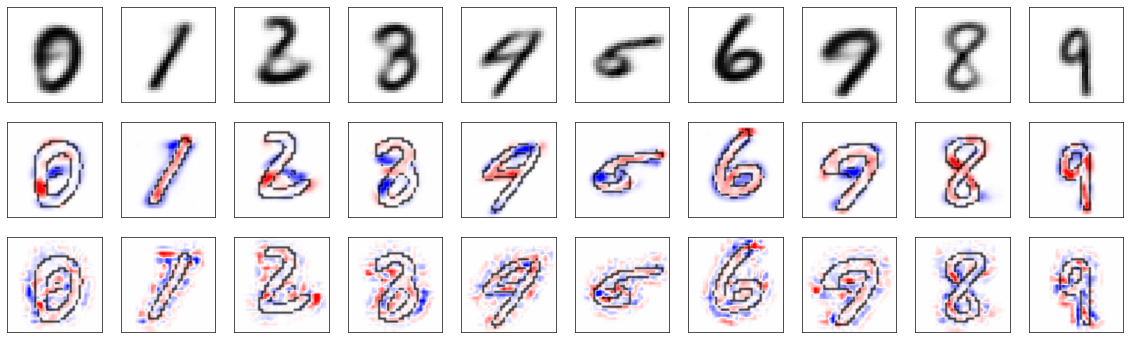

In [15]:
np.random.seed(2)
grad_max_indices = on_off_plot(grad_list, frac_grad_its, True)

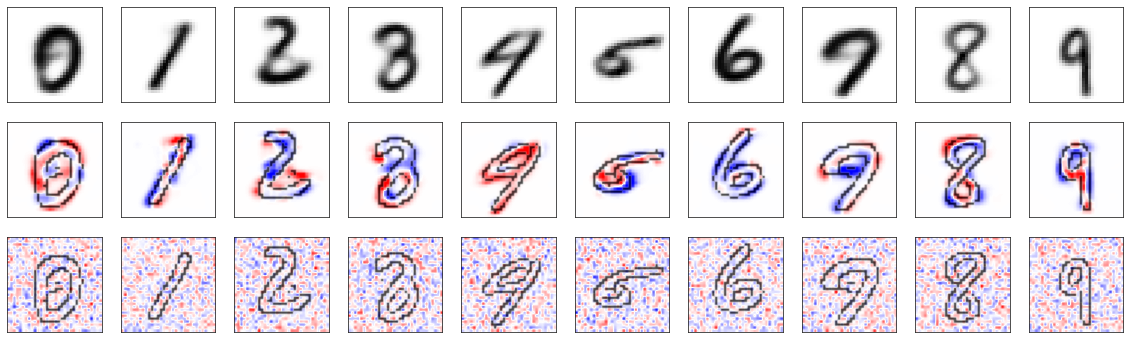

In [16]:
np.random.seed(1)
visualize(model, [inputs[i] for i in grad_max_indices], [np.random.normal(size=(32, 32)) for i in range(10)], [t_monitor[i] for i in grad_max_indices], show_predictions=False)
plt.savefig('./figures/random_attribution.pdf', bbox_inches = "tight")

# Figure 2 in the paper

In [96]:
import matplotlib.pyplot as plt

plt.rc('font', size=13) #controls default text size
plt.rc('axes', titlesize=13) #fontsize of the title
plt.rc('axes', labelsize=13) #fontsize of the x and y labels
plt.rc('xtick', labelsize=13) #fontsize of the x tick labels
plt.rc('ytick', labelsize=13) #fontsize of the y tick labels
plt.rc('legend', fontsize=13) #fontsize of the legend

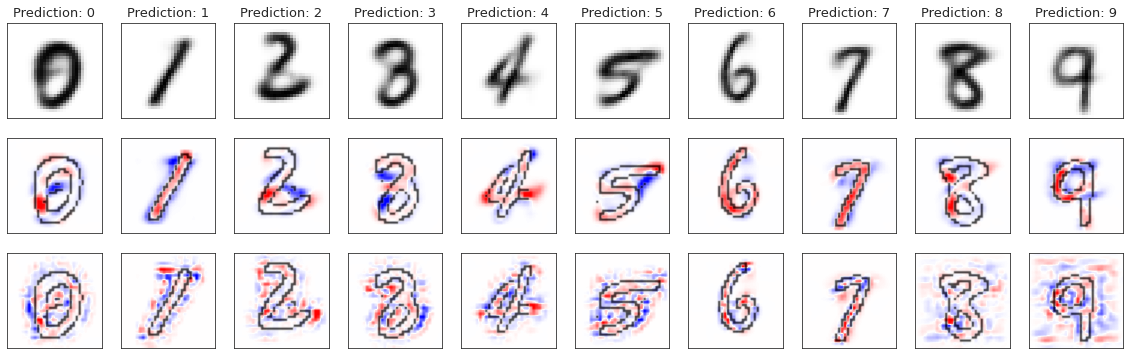

In [129]:
images = [ inputs[grad_max_indices[0]], inputs[grad_max_indices[1]], inputs[grad_max_indices[2]], inputs[grad_max_indices[3]],
           inputs[int_grad_max_indices[4]], inputs[int_grad_max_indices[5]],
           inputs[ixg_grad_max_indices[6]], inputs[ixg_grad_max_indices[7]],
           inputs[sg_grad_max_indices[8]], inputs[sg_grad_max_indices[9]] ]
          
attributions = [ grad_list[grad_max_indices[0]], grad_list[grad_max_indices[1]], grad_list[grad_max_indices[2]], grad_list[grad_max_indices[3]],
                 int_grad_list[int_grad_max_indices[4]], int_grad_list[int_grad_max_indices[5]],
                 igx_list[ixg_grad_max_indices[6]], igx_list[ixg_grad_max_indices[7]],
                 smooth_grad_list[sg_grad_max_indices[8]], smooth_grad_list[sg_grad_max_indices[9]] ]
               
tsp    = [ t_monitor[grad_max_indices[0]], t_monitor[grad_max_indices[1]], t_monitor[grad_max_indices[2]], t_monitor[grad_max_indices[3]],
           t_monitor[int_grad_max_indices[4]], t_monitor[int_grad_max_indices[5]],
           t_monitor[ixg_grad_max_indices[6]], t_monitor[ixg_grad_max_indices[7]],
           t_monitor[sg_grad_max_indices[8]], t_monitor[sg_grad_max_indices[9]] ]


visualize(model, images, attributions, tsp)
#plt.text(x=-352, y=-56, s='Image', rotation='vertical')
#plt.text(x=-358, y=-8, s='  Part inside\ntangent space', rotation='vertical')
#plt.text(x=-358, y=28, s='  Part outside\ntangent space', rotation='vertical')
plt.savefig('mnist32_images.pdf')
plt.show()

# Comparison with robust models

In [10]:
standard_model, _ = model_and_optimizer()
standard_model.load_state_dict(torch.load('./models/mnist32_lenet.pth'))
standard_model.to(device)
standard_model.eval()
util.test(standard_model, testloader, device)

l2_robust_model, _ = model_and_optimizer()
l2_robust_model.load_state_dict(torch.load("./models/mnist_32_adv_robust_l2.pt"))
l2_robust_model.to(device)
l2_robust_model.eval()
util.test(l2_robust_model, testloader, device)

Test Error:  0.0103
Test Error:  0.0218


0.0218

In [11]:
inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]
standard_grad_list, _, _ = util.compute_saliency_maps(standard_model, inputs)
l2_robust_grad_list, _, _ = util.compute_saliency_maps(l2_robust_model, inputs)

10000it [03:22, 49.47it/s]
10000it [03:36, 46.12it/s]


In [12]:
frac_standard_grad_its = util.tangent_space_ratio(standard_grad_list, t_monitor)
frac_l2_robust_grad_its = util.tangent_space_ratio(l2_robust_grad_list, t_monitor)

In [13]:
np.mean(frac_standard_grad_its), np.mean(frac_l2_robust_grad_its)

(0.31175304737826487, 0.6754392813279381)

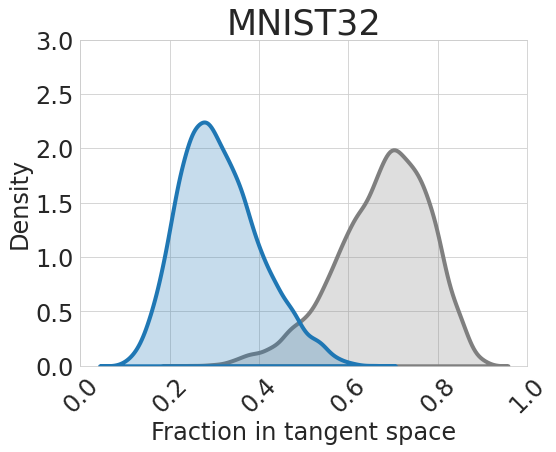

In [64]:
val_pair = []
for v in frac_standard_grad_its:
    val_pair.append((v, 'Gradient'))
for v in frac_l2_robust_grad_its:
    val_pair.append((v, 'Robust Gradient'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25, palette={'Gradient': 'tab:blue', 'Robust Gradient': sns.color_palette()[7]})
#plt.legend(labels=['Robust Gradient', 'Gradient'], fontsize=24) #  , loc='upper left'
plt.xlim([0., 1.])
plt.ylim([0., 3])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
plt.title("MNIST32", fontsize=35)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.savefig('./figures/mnist32_robust.pdf', bbox_inches='tight')
plt.show()

In [2]:
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [3]:
# avoid type-3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42